## Exploratory data analysis 

This notebook is meant to explore the well test data

In [1]:
#import packages
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from agents.utils.utils import make_plot_2y, make_plot
from scipy.optimize import curve_fit


In [2]:
#Load data - cheetah-20 as example
df = pd.read_csv('data/cheetah-20.csv')

#Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(df['Date'], inplace=True)

        
#Select well test columns
df_subset = df[['Date', 'WT LIQ', 'WT THP', 'WT WCT', 'WT GL', 'WT Oil']].copy()
df_subset.dropna(inplace = True)
df_subset_og = df_subset.copy()


In [3]:
#Clean the dataset by removing outliers in oil rate iteratively

def remove_outliers(df_subset, threshold=0.4):
    """
    Remove outliers from the dataset based on the specified threshold.
    """
    df_subset = df_subset.copy()
    clean_rate = [df_subset['WT Oil'].iloc[0], df_subset['WT Oil'].iloc[1]]
    index_list = [df_subset.index[0]]
    
    for index, row in df_subset.iterrows():
        diff = np.log(row['WT Oil']/clean_rate[-1])
        if diff > -threshold:
            clean_rate.append(row['WT Oil'])
            index_list.append(index)
    
    df_subset = df_subset.loc[index_list]

    return df_subset

#Remove outliers
df_subset = remove_outliers(df_subset, 0.35)

<Axes: xlabel='Date'>

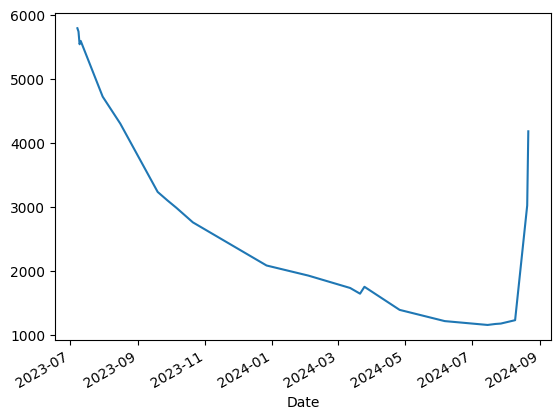

In [4]:
df_subset['WT Oil'].plot()

In [5]:
# Function to fit the decline curve
def fit_decline_curve(data, time_col, rate_col, auto = True, qi = None, Di = None, type = 'exponential'):
    # Extract time and rate data
    t = data[time_col]
    q = data[rate_col]

    # Define the exponential decline function
    def exponential_decline(t, qi, Di):
        return qi * np.exp(-Di * t)

    #Define the hyperbolic decline function
    def hyperbolic_decline(t, qi, b, Di):
        return qi/((1.0+b*Di*t)**(1.0/b))
    
    if auto == True:
        if type == 'hyperbolic':

            # Initial guesses for the parameters
            qi_initial = 8000 # Example initial guess for qi
            b_initial = 0.5 # Example initial guess for b
            Di_initial = 0.05 # Example initial guess for Di

            # Bounds for the parameters
            qi_max = 9000 # Example maximum value for qi
            b_max = 1.0 # Example maximum value for b
            Di_max = 0.2 # Example maximum value for Di

            # Fit the hyperbolic decline curve
            popt, _ = curve_fit(hyperbolic_decline, t, q, 
                                p0=[qi_initial, b_initial, Di_initial],
                                bounds=(0, [qi_max, b_max, Di_max]),
                                maxfev=100000)

            # Generate fitted values
            q_fit = hyperbolic_decline(t, *popt)

        elif type == 'exponential':
            # Fit the exponential decline curve
            popt, _ = curve_fit(exponential_decline, t, q, maxfev=10000)

            # Extract fitted parameters
            qi, Di = popt

            # Generate fitted values
            q_fit = exponential_decline(t, qi, Di)
        else:
            raise ValueError("Invalid type. Choose 'exponential' or 'hyperbolic'.")
    else: #Define the parameters manually
        qi = 6000
        Di = 0.008
        q_fit = exponential_decline(t, qi, Di)
    
    # Return fitted parameters and values
    return q_fit

# Fit the decline recursively
def recursive_fit(data, time_col, rate_col, auto = True, qi = None, Di = None, type_ = 'hyperbolic'):
    # Initialize lists to store fitted parameters and values
    q_fit_list = []

    # Loop through the data in chunks
    for i in range(4, len(data)+1):
        chunk = data.tail(i)
        chunk[time_col] = (chunk['Date'] - chunk['Date'].min()).dt.days
        q_fit = fit_decline_curve(chunk, time_col, rate_col, auto, qi, Di, type=type_)
        
        # Append fitted values and values to the lists
        q_fit_list.append(q_fit)

    return q_fit_list

### Testing recursive DCA fitting

/tmp/ipykernel_2815/211786757.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[time_col] = (chunk['Date'] - chunk['Date'].min()).dt.days
/tmp/ipykernel_2815/211786757.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[time_col] = (chunk['Date'] - chunk['Date'].min()).dt.days
/tmp/ipykernel_2815/211786757.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

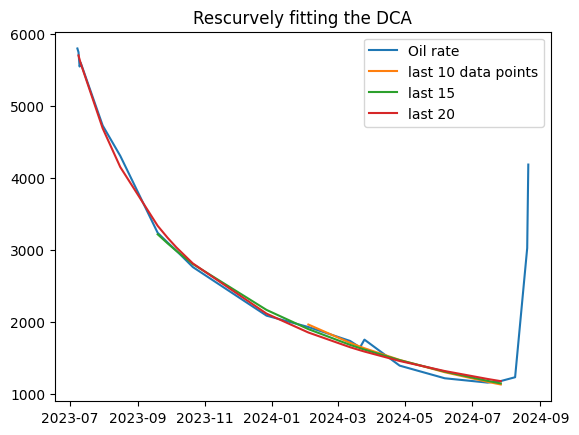

In [12]:
#try the recursive fit
df_subset_24 = df_subset[df_subset['Date'] < '2024-08-01'].copy()
q_fit_list = recursive_fit(df_subset_24, 'Days', 'WT Oil', auto = True, type_ = 'hyperbolic')

import matplotlib.pyplot as plt
#plt.plot(q_fit)
plt.plot(df_subset['WT Oil'])
#plt.plot(q_fit_list[1])
plt.plot(q_fit_list[5])
plt.plot(q_fit_list[10])
plt.plot(q_fit_list[15])

plt.title('Rescurvely fitting the DCA')
plt.legend(['Oil rate', 'last 10 data points', 'last 15', 'last 20', 'last 25', 'All'])

######################################
# Conclusion: This method does not work
######################################


/tmp/ipykernel_2815/211786757.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[time_col] = (chunk['Date'] - chunk['Date'].min()).dt.days
/tmp/ipykernel_2815/211786757.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[time_col] = (chunk['Date'] - chunk['Date'].min()).dt.days
/tmp/ipykernel_2815/211786757.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

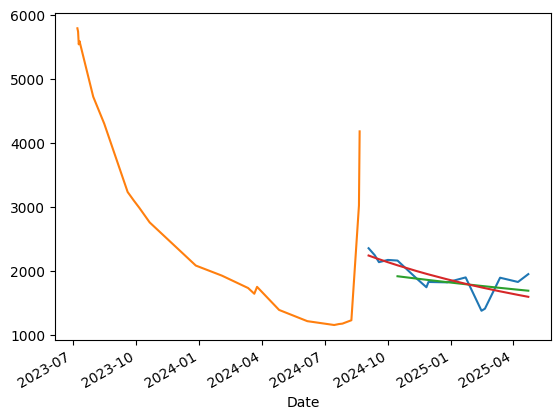

In [13]:
df_subset_ac_stim = df_subset_og[df_subset_og['Date'] > '2024-08-21'].copy()
#df_subset_ac_stim['WT Oil'].plot()
#Remove outliers
df_subset_ac_stim = remove_outliers(df_subset_ac_stim, 0.35)
df_subset_ac_stim['WT Oil'].plot()
q_fit_list = recursive_fit(df_subset_ac_stim, 'Days', 'WT Oil', auto = True, type_ ='hyperbolic')

#plt.plot(q_fit)
plt.plot(df_subset['WT Oil'])
plt.plot(q_fit_list[7])
plt.plot(q_fit_list[12])



######################################
# Conclusion: This method does not work
######################################

### Testing Polynomial regression

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Fit the decline recursively
def poly_fit(data, time_col, rate_col):
    # Initialize lists to store fitted parameters and values
    prediction = []

    # Loop through the data in chunks
    for i in range(4, len(data)+1, 4):
        chunk = data.iloc[0:i]
        chunk[time_col] = (chunk['Date'] - chunk['Date'].min()).dt.days
        x = chunk[time_col].values.reshape(-1, 1)
        y = chunk[rate_col].values.reshape(-1, 1)
        
        #Define the model
        poly_model = PolynomialFeatures(degree=4)
        x_poly = poly_model.fit_transform(x)
        lr_model = LinearRegression()
        lr_model.fit(x_poly, y)

        y_pred = lr_model.predict(x_poly)
        
        chunk['poly_predicted'] = y_pred
        
        # Append fitted parameters and values to the lists
        prediction.append(chunk['poly_predicted'])

    return prediction, lr_model, poly_model

/tmp/ipykernel_2815/826072018.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[time_col] = (chunk['Date'] - chunk['Date'].min()).dt.days
/tmp/ipykernel_2815/826072018.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['poly_predicted'] = y_pred
/tmp/ipykernel_2815/826072018.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

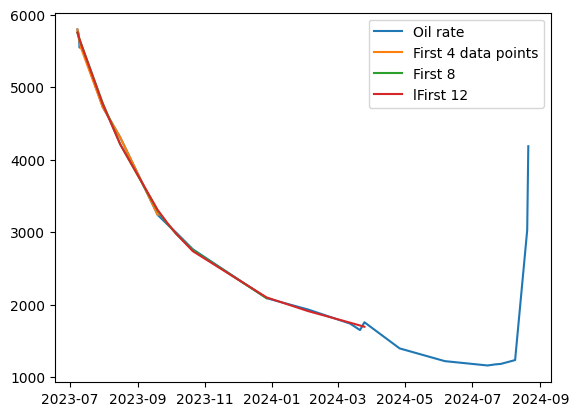

In [15]:
import matplotlib.pyplot as plt

# Try the polynomial prediction
prediction, lr_model, poly_model = poly_fit(df_subset_24, 'Days', 'WT Oil')

#plt.plot(q_fit)
plt.plot(df_subset['WT Oil'])
plt.plot(prediction[1])
plt.plot(prediction[2])
plt.plot(prediction[3])


plt.title('')
plt.legend(['Oil rate', 'First 4 data points', 'First 8', 'lFirst 12', 'First 16', 'All'])

(0.0, 7000.0)

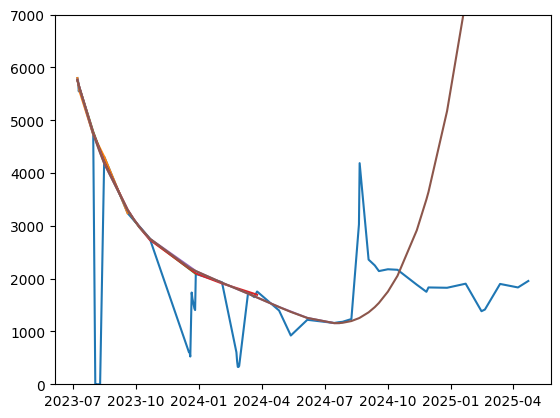

In [16]:

# Try the polynomial prediction on future dates

#predict the future - use original dataframe
x_future = (df_subset_og['Date'] - df_subset_og['Date'].min()).dt.days
x_future = x_future.values.reshape(-1, 1)
x_future_poly = poly_model.fit_transform(x_future)
y_future = lr_model.predict(x_future_poly)

df_subset_og['poly_predicted'] = y_future

#plt.plot(q_fit)
plt.plot(df_subset_og['WT Oil'])
plt.plot(prediction[1])
plt.plot(prediction[2])
plt.plot(prediction[3])
plt.plot(prediction[4])
plt.plot(df_subset_og['poly_predicted'])
plt.ylim(0, 7000)
